In [0]:
import cv2 
import matplotlib.pyplot as plt 
import csv 
import numpy as np 
import os 
import sys 
import glob 
from PIL import Image
import math
from scipy import signal

#Major Referance.
#https://yangcha.github.io/iview/iview.html

# GIF Maker 

In [0]:
def gifMaker(dataPath,optPath,filename,imgType='.png'):
    #Read the filenames,and order the frames.
    fileNames=sorted([fn for fn in os.listdir(dataPath) if fn.endswith(str(imgType))])
    imgArr=[]
    for file in fileNames:
        img=cv2.imread(str(dataPath)+'//'+str(file))
        h,w,l=img.shape
        size=(w,h)
        imgArr.append(img)
    #Output video writer.
    out=cv2.VideoWriter(optPath+'//'+str(filename)+'.avi',cv2.VideoWriter_fourcc(*'DIVX'),30,size)
    #Append the images to the writer.
    for i in range(len(imgArr)):
        out.write(imgArr[i])
    #Release it .
    out.release()
    print('Video created ..')

In [0]:
datapath='/content/drive/My Drive/eval-gray-twoframes/eval-data-gray/Army'
op='/content/drive/My Drive/eval-gray-twoframes/eval-data-gray/Army'
gifname='army'
gifMaker(datapath,op,gifname)

Video created ..


In [0]:
# Load all the images in .content file .
dataPath="/content/drive/My Drive/eval-gray-twoframes/eval-data-gray/Army"
imgType=".png"
imgArr=[]
fileNames=sorted([fn for fn in os.listdir(dataPath) if fn.endswith(str(imgType))])
for file in fileNames:# Load all the images in .content file .
dataPath="/content/drive/My Drive/eval-gray-twoframes/eval-data-gray/Army"
imgType=".png"
imgArr=[]
fileNames=sorted([fn for fn in os.listdir(dataPath) if fn.endswith(str(imgType))])
for file in fileNames:
  img=cv2.imread(str(dataPath)+'/'+str(file))
  imgArr.append(img)
print(fileNames)
  img=cv2.imread(str(dataPath)+'/'+str(file))
  imgArr.append(img)
print(fileNames)

['frame10.png', 'frame11.png']


In [0]:
# Sample images for testing out Lucas Kanade (Dense)
im1=np.asarray(imgArr[0])
im2=np.asarray(imgArr[1])

im1h=cv2.resize(im1, (0, 0), fx = 0.2, fy = 0.2) 
im2h=cv2.resize(im2, (0, 0), fx = 0.2, fy = 0.2) 

#  Resizing it to smaller shapes cause no power in my laptop.
print(im1h.shape)
print(im2h.shape)

(78, 117, 3)
(78, 117, 3)


In [0]:
# Main function : 
def LucasKanade(frame1,frame2,windowSize=(3,3),verbose=True):
    #Default Params
    thresh=1e-3

    #Input Errors 
    assert(frame1.shape==frame2.shape),"InputError:Wrong combination of frames,check the frame shapes."
    assert((windowSize[0]==windowSize[1])and(windowSize[0]%2!=0)),"InputError:Window Size must be odd number"
    
    #Shape.
    stride=math.floor(windowSize[0]/2)
    M,N,C=frame1.shape

    vecMap=[]
    magMap=[]
    totalNum=windowSize[0]*windowSize[1]
    
    #Convert gray.
    if(C==3):
      frame1g=cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
      frame2g=cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    
    frame1g=np.asarray(frame1g)
    frame1g=np.asarray(frame1g)
  

    #Gradients.
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])

    It=signal.convolve2d(abs(frame1g-frame2g), kernel_x, boundary='symm', mode='same')
    Ix=signal.convolve2d(frame1g, kernel_x, boundary='symm', mode='same') 
    Iy=signal.convolve2d(frame1g, kernel_x, boundary='symm', mode='same') 

    #Storing results .
    # u direction :
    U=np.zeros((M,N)) 
    # v direction :
    V=np.zeros((M,N))
    # Magnitude Map : 
    Mag=np.zeros((M,N))
    
    #Iterating through the image.
    for i in range(stride,M-stride,1):
        for j in range(stride,N-stride,1):
            # Window Selection.
            Ax=Ix[i-stride:i+stride+1,j-stride:j+stride+1].flatten()
            Ay=Iy[i-stride:i+stride+1,j-stride:j+stride+1].flatten()
            At=It[i-stride:i+stride+1,j-stride:j+stride+1].flatten()

            #Get ur A
            A=np.hstack((Ax,Ay)).reshape((-1,2))
            #Get your b 
            b=np.asarray(At).reshape((totalNum,1))
            A_inv=np.linalg.pinv(A)
            
            # print('A shape:',A.shape)
            # print('b shape:',b.shape)
            opVec=np.matmul(A_inv,-1*b)
            #print(opVec)
            magVec=np.linalg.norm(opVec)
            #print(magVec)
            Mag[i][j]=magVec
            U[i][j]=opVec[0]
            V[i][j]=opVec[1] 
    if(verbose):
      imgArr=[im1h,Mag]
      fig, (ax1, ax2) = plt.subplots(1, 2)
      fig.set_figheight(10)
      fig.set_figwidth(10)
      fig.suptitle('Image & Magnitude Map')
      ax1.imshow(imgArr[0])
      ax2.imshow(imgArr[1])
      plt.show()

    return(Mag,U,V)

In [0]:
M,U,V=LucasKanade(im1h,im2h,windowSize=(3,3),verbose=False)
print(V.shape)
print(U.shape)

(78, 117)
(78, 117)


# Displaying Results

In [0]:

def display_opticalflow_results(im1,im2,u,v,fig_size=(16,16),arrow_thres=0.02):
    """
        Display results of optical flow
        @param img_list:=> mxn matrix of images to be displayed
        @param shape:=> mxn shape
        @param is_gray:=> mxn matrix, is the i,j th the image grayscaled
    
        return None
    """
    
    fig = plt.figure(figsize=fig_size)
    
    #Images
    ax = fig.add_subplot(3,2,1)
    ax.imshow(im1,cmap='gray')
    ax.set_title("Image T:1")
    ax.axis('off')
    
    ax = fig.add_subplot(3,2,2)
    ax.imshow(im2,cmap='gray')
    ax.set_title("Image T:2")
    ax.axis('off')
    
    # Vectors     
    ax = fig.add_subplot(3,2,3)
    ax.imshow(u,cmap='gray')
    ax.set_title("U")
    ax.axis('off')
    
    ax = fig.add_subplot(3,2,4)
    ax.imshow(v,cmap='viridis')
    ax.set_title("V")
    ax.axis('off')
    
    # Magnitude     
    ax = fig.add_subplot(3,2,5)
    ax.imshow(u*u + v*v,cmap='coolwarm')
    ax.set_title("U^2 + V^2")
    ax.axis('off')
    
    # Angle
    ax = fig.add_subplot(3,2,6)
    ax.imshow(np.arctan2(v,u),cmap='plasma')
    ax.set_title("arc(v/u)")
    ax.axis('off')

    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(1,2,1)
    ax.imshow(im1,cmap='gist_heat')
    ax.set_title("Optical flow Arrows")
    
#   arrow_ind_y,arrow_ind_x = np.where(u*u + v*v > arrow_thres)
    gray = cv2.cvtColor(im1, cv2.COLOR_RGBGR2GRAY)
    kp = cv2.goodFeaturesToTrack(im1, 100, 0.01, 10, 3)
    for arrow_ind in kp:
        x,y = arrow_ind[0]
        y = int(y)
        x = int(x)
        ax.arrow(x,y,u[y,x],v[y,x],head_width = 1, head_length = 5, color = (0,1,0))
        
    ax = fig.add_subplot(1,2,2)
    ax.imshow( (u*u + v*v>arrow_thres),cmap='Wistia')
    ax.set_title("Optical flow Mask")
    
    ax.axis('off')
    plt.show()
    return None 

(78, 117, 3)
(78, 117, 3)


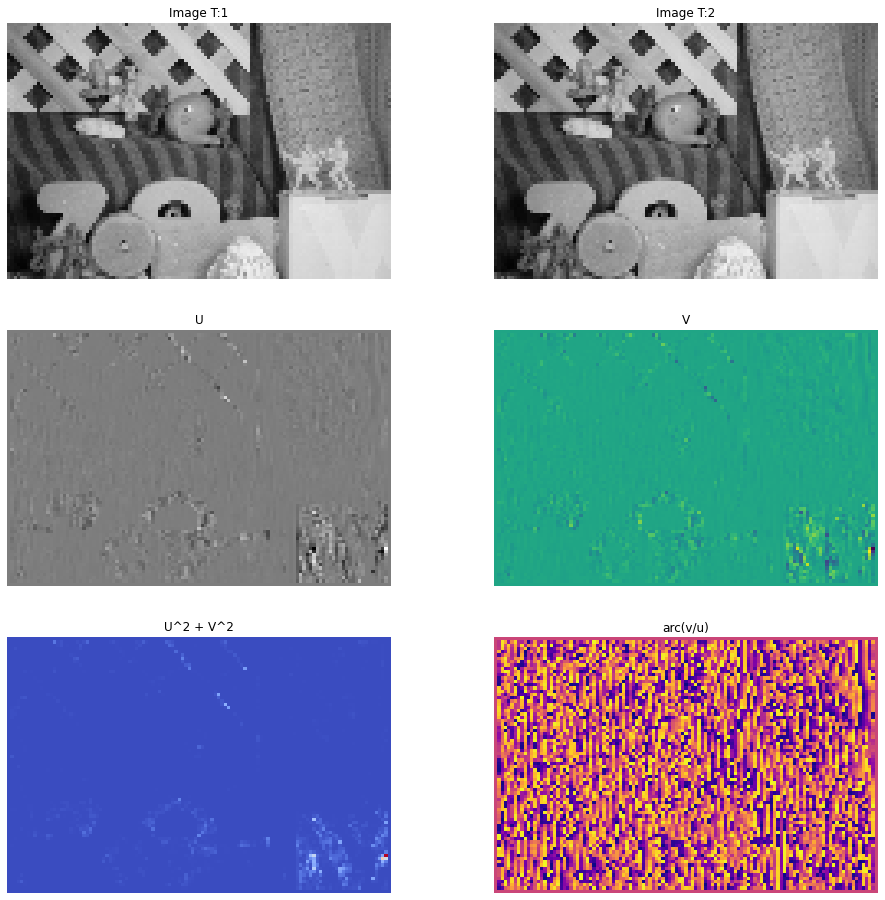

In [0]:
# Testing it out here.

display_opticalflow_results(im1h,im2h,U,V)

In [0]:
# Multiple Plots Function . 

def multiplePlots(I1,I2,U,V,MagMap,flag=True):
  I1=np.asarray(I1)
  I2=np.asarray(I2)
  U=np.asarray(U)
  V=np.asarray(V)
  
  #NAME
  names=['Frame at (t)','Frame at (t+1)','U','V']
  imArr=[I1,I2,U,V,MagMap]

  # #Plot both I1 & I2.
  # fig=plt.figure(figsize=[100,4*100])
  # for i in range(len(imgArr)):
  #   plt.subplot(1,4,i+1)
  #   plt.xticks([])
  #   plt.yticks([])
  #   plt.grid(False)
  #   plt.imshow(imgArr[i], cmap='viridis')
  #   plt.xlabel('Frame number'+str(i+1))
  # plt.title('Time Lapse')
  # plt.show()

  if(flag):
    fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4)
    ax1.imshow(imArr[0])
    ax1.set_title('First Frame')
    ax2.imshow(imArr[1])
    ax2.set_title('Second Frame')
    ax3.imshow(imArr[2])
    ax3.set_title('U vector map')
    ax4.imshow(imArr[3])
    ax4.set_title('V vector map')
    plt.title('Entire Frame Movement')
    plt.show()
    




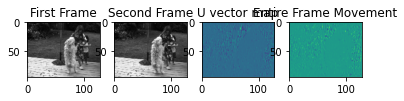

In [0]:
# Testing the multiple plots .
#multiplePlots(im1h,im2h,U,V,M)

# Object Detection 

In [0]:
import cv2 as cv
import numpy as np

def objectDetection(videoPath,optPath,opName):
  # The video feed is read in as a VideoCapture object
  cap = cv.VideoCapture("kaka.avi")
  # ret = a boolean return value from getting the frame, first_frame = the first frame in the entire video sequence
  ret, first_frame = cap.read()
  # Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally expensive
  prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)
  # Creates an image filled with zero intensities with the same dimensions as the frame
  mask = np.zeros_like(first_frame)
  # Sets image saturation to maximum
  mask[..., 1] = 255
  count=0
  while(cap.isOpened()):
    count=count+1
    # ret = a boolean return value from getting the frame, frame = the current frame being projected in the video
    ret, frame = cap.read()
    # Opens a new window and displays the input frame
    #cv.imshow("input", frame)
    # Converts each frame to grayscale - we previously only converted the first frame to grayscale
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # Calculates dense optical flow by Farneback method

    flow = cv.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    # Computes the magnitude and angle of the 2D vectors
    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])
    # Sets image hue according to the optical flow direction
    mask[..., 0] = angle * 180 / np.pi / 2
    # Sets image value according to the optical flow magnitude (normalized)
    mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
    # Converts HSV to RGB (BGR) color representation
    rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)
    # Opens a new window and displays the output frame
    fig=plt.figure(figsize=[10,10])
    plt.imshow(rgb)
    plt.title('Motion Segmenration')
    cv.imwrite(optPath+'/'+str(opName)+'.jpg',rgb)
    # Updates previous frame
    prev_gray = gray
    # Frames are read by intervals of 1 millisecond. The programs breaks out of the while loop when the user presses the 'q' key
    if( cv.waitKey(10) or 0xFF == ord('q') ):
        break
    # The following frees up resources and closes all windows
  cap.release()
  cv.destroyAllWindows()

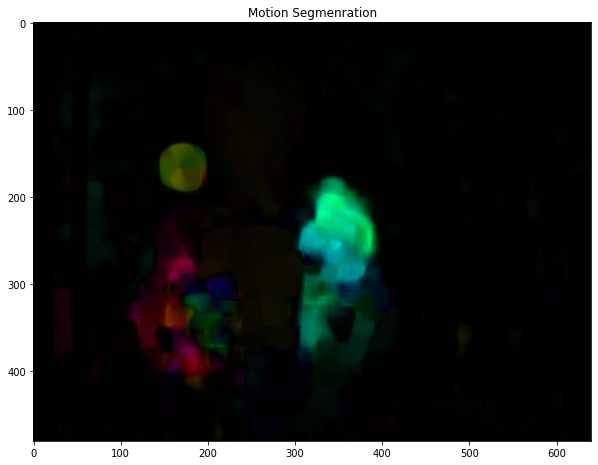

In [0]:
# Video Capture process .
videoPath='/content/kaka.avi'
optPath='/content/'
objectDetection(videoPath,optPath,opName='juggle_op')

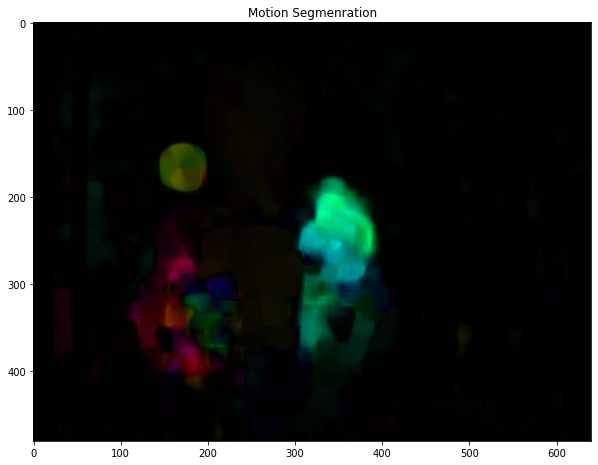

In [0]:
# Video Capture process .
videoPath='/content/dogvideo.avi'
optPath='/content/'
objectDetection(videoPath,optPath,'dog_opt')

# Display results 


# Object Detection Part 

True

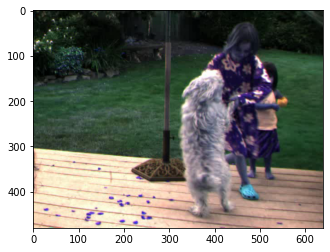

In [0]:
# Track a damn window thats all . 
# The video feed is read in as a VideoCapture object
cap = cv.VideoCapture("dogvideo.avi")
# ret = a boolean return value from getting the frame, first_frame = the first frame in the entire video sequence
ret, first_frame = cap.read()
plt.imshow(first_frame)
cv2.imwrite('ff.jpg',first_frame)


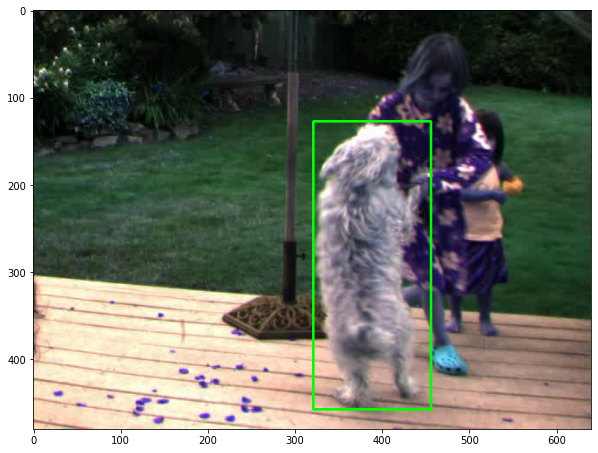

In [0]:
dogBox=[321,127,135,330]
x=dogBox[0]
y=dogBox[1]
w=dogBox[2]
h=dogBox[3]
img=cv2.imread('ff.jpg')
# draw a green rectangle to visualize the bounding rect
I=cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
fig=plt.figure(figsize=[10,10])
plt.imshow(I)

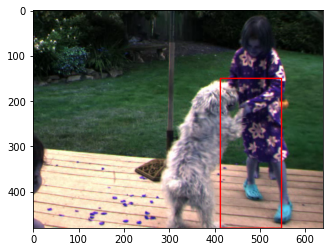

In [0]:
# Now , track the damn dog accross the frames .
import cv2 as cv

cap = cv.VideoCapture('dogvideo.avi')
optPath='/content/dogpop/'

# take first frame of the video
ret,frame = cap.read()
# setup initial location of window

x, y, w, h = [321,127,135,330]
track_window = (x, y, w, h)
# set up the ROI for tracking
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)
# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )
c=0
while(1):
    c=c+1
    ret, frame = cap.read()
    if ret == True:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        # apply meanshift to get the new location
        ret, track_window = cv.meanShift(dst, track_window, term_crit)
        # Draw it on image
        x,y,w,h = track_window
        img2 = cv.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        cv2.imwrite(optPath+'/'+str(c)+'.jpg',img2)
        plt.imshow(img2)
        k = cv.waitKey(30) or 0xff
        if k == 27:
            break
    else:
        break